In [1]:
import numpy as np
from Digital_twin import DigitalTwin
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

pygame 2.6.1 (SDL 2.28.4, Python 3.12.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


21.9389585205884 found a better error
21.496951655221267 found a better error
20.641478947912276 found a better error
19.822459549724908 found a better error
19.037604365254595 found a better error
18.278051345270477 found a better error
17.558123267351586 found a better error
16.86684657135572 found a better error
16.2176946337292 found a better error
15.595885633632221 found a better error
15.060862417515857 found a better error
14.505227596728458 found a better error
13.99603454336388 found a better error
13.502191139292592 found a better error
13.043867555998196 found a better error
12.612208810742192 found a better error
12.211350808234236 found a better error
11.841227776129939 found a better error
11.513543594825233 found a better error
10.922296794263918 found a better error
10.339559465692261 found a better error
9.773245692923064 found a better error
9.215270045630152 found a better error
8.663195520408191 found a better error
8.117309237808033 found a better error
7.58934555

/var/folders/lm/hkt5kj_d5xj13bc2cb4x2wg80000gn/T/ipykernel_30210/493803634.py:48: RuntimeWarning: overflow encountered in square
  rmse = np.sqrt(np.mean((theta_measurements - sim_measurements) ** 2))
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/alishirazi/Desktop/Master SSE/Smart Systems/Group team/Smart-syetems-labs/Digital_twin.py:279: RuntimeWarning: overflow encountered in scalar multiply
  torque_coulomb_friction = -(self.c_c / (self.I + self.mp * self.l**2)) * theta_dot
/Users/alishirazi/Desktop/Master SSE/Smart Systems/Group team/Smart-syetems-labs/Digital_twin.py:271: RuntimeWarning: invalid value encountered in sin
  torque_gravity = -(self.mp * self.g * self.l / (self.I + self.mp * self.l**2)) * np.sin(theta)
/Users/alishirazi/Desktop/Master SSE/Smart Systems/Group team/Smart-syetems-labs/Digital_twin.py:282: RuntimeWarning: invalid value encountered in cos
  tor

4.968320034053526 found a better error
4.590145688161165 found a better error
4.252642170426649 found a better error
3.8660877300799688 found a better error
3.488533210672184 found a better error
3.4831801860029232 found a better error
3.033286403945374 found a better error
3.0220918199536793 found a better error
Best Parameters: (0.05263631578947369, 1e-05, 1.9489743589743591)
Lowest Error: 3.0220918199536793
expected Error:  8.626934844006886


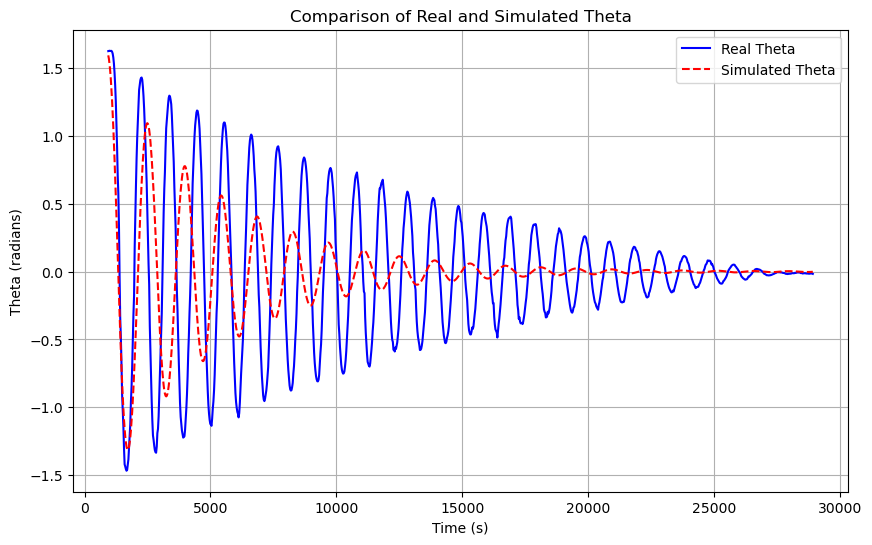

In [2]:

digital_twin = DigitalTwin()
# digital_twin.get_theta_double_dot()
# Path to the CSV file
csv_file_path = '/Users/alishirazi/Desktop/Master SSE/Smart Systems/Group team/Smart-syetems-labs/theta.csv'
df = pd.read_csv(csv_file_path)
df_time = df['pcTime'][20:] 
df_theta = df['theta'][20:]

#Process dt_theta such that it is translated to radians.

def find_initial_state(df_theta, df_time):
    # Find the initial conditions of theta and theta_dot in the data
    theta = 92.0 * np.pi / 180  # Convert degrees to radians
    theta_dot = 0
    return theta, theta_dot

#Initial conditions based on the recorded data
theta, theta_dot = find_initial_state(df_theta, df_time)
#should be the same as your recording, sim_time is equal to total time of the recording
delta_t = 0.025  # Time step
sim_time = 0.025 * len(df_theta)  # Total time of the simulation

# Define improved parameter ranges with higher resolution
I_range = np.linspace(0.00001, 0.1, 20)      # Reduced upper bound, increased resolution
c_c_range = np.linspace(0.00001, 0.1, 20)    # Increased upper bound, increased resolution  
g = 9.81                                   # Gravity constant
mp_range = np.linspace(0.01, 2, 40)       # Expanded range in both directions, increased resolution
l = 0.35

def simulate_potential_model(theta, theta_dot, I, c_c, g, mp, theta_measurements):
    digital_twin.I = I
    digital_twin.c_c = c_c
    digital_twin.g = g
    digital_twin.mp = mp
    digital_twin.l = l

    sim_measurements = []
    for _ in range(len(theta_measurements)):
        theta_double_dot = digital_twin.get_theta_double_dot(theta, theta_dot)
        theta_dot += theta_double_dot * delta_t
        theta += theta_dot * delta_t
        sim_measurements.append(theta)

    sim_measurements = np.array(sim_measurements)
    theta_measurements = np.array(theta_measurements)

    # 1. Basic RMSE
    rmse = np.sqrt(np.mean((theta_measurements - sim_measurements) ** 2))

    # 2. Frequency Domain Analysis
    # Calculate frequencies
    freq = np.fft.fftfreq(len(theta_measurements), d=delta_t)
    fft_measured = np.fft.fft(theta_measurements)
    fft_sim = np.fft.fft(sim_measurements)
    
    # Only consider positive frequencies up to Nyquist frequency
    pos_freq_mask = freq > 0
    pos_freq = freq[pos_freq_mask]
    fft_measured_pos = fft_measured[pos_freq_mask]
    fft_sim_pos = fft_sim[pos_freq_mask]

    # Find dominant frequencies (top 3 peaks)
    N = 3  # Number of dominant frequencies to consider
    measured_peaks = np.argsort(np.abs(fft_measured_pos))[-N:]
    sim_peaks = np.argsort(np.abs(fft_sim_pos))[-N:]
    
    # Compare magnitude and phase of dominant frequencies
    freq_error = np.mean(np.abs(measured_peaks - sim_peaks))
    magnitude_error = np.mean(np.abs(np.abs(fft_measured_pos[measured_peaks]) - 
                                    np.abs(fft_sim_pos[sim_peaks])))
    phase_error_freq = np.mean(np.abs(np.angle(fft_measured_pos[measured_peaks]) - 
                                    np.angle(fft_sim_pos[sim_peaks])))

    # 3. Natural Frequency Analysis
    natural_freq = np.sqrt(g/l)  # theoretical natural frequency
    measured_dom_freq = pos_freq[np.argmax(np.abs(fft_measured_pos))]
    sim_dom_freq = pos_freq[np.argmax(np.abs(fft_sim_pos))]
    
    freq_penalty = np.abs(measured_dom_freq - sim_dom_freq)
    natural_freq_penalty = np.abs(measured_dom_freq - natural_freq)

    # 4. Time-windowed Analysis
    window_size = len(theta_measurements) // 4
    n_windows = 4
    window_errors = []
    
    for i in range(n_windows):
        start_idx = i * window_size
        end_idx = (i + 1) * window_size
        
        window_measured = theta_measurements[start_idx:end_idx]
        window_sim = sim_measurements[start_idx:end_idx]
        
        # Calculate FFT for window
        fft_measured_window = np.fft.fft(window_measured)
        fft_sim_window = np.fft.fft(window_sim)
        
        # Calculate error for this window
        window_error = np.mean(np.abs(fft_measured_window - fft_sim_window))
        window_errors.append(window_error)
    
    # Time-varying frequency error
    freq_evolution_error = np.mean(window_errors)

    # 5. Phase Alignment (using cross-correlation)
    cross_corr = np.correlate(theta_measurements - np.mean(theta_measurements),
                            sim_measurements - np.mean(sim_measurements), mode='full')
    max_corr = np.max(cross_corr)
    phase_error_time = 1 - (max_corr / (np.std(theta_measurements) * 
                                        np.std(sim_measurements) * 
                                        len(theta_measurements)))

    # Combine all error components with weights
    total_error = (
        0.15 * rmse +                    # Basic time-domain error
        0.20 * freq_error +              # Dominant frequency matching
        0.15 * magnitude_error +         # Frequency magnitude matching
        0.10 * phase_error_freq +        # Frequency domain phase matching
        0.10 * freq_penalty +            # Dominant frequency difference
        0.10 * natural_freq_penalty +    # Natural frequency matching
        0.10 * freq_evolution_error +    # Time-windowed frequency analysis
        0.10 * phase_error_time          # Time-domain phase matching
    )

    return total_error


#example usage
exp_err = simulate_potential_model(np.pi-0.5, -0.1, 0.16, 1.1, 9.81 ,0.3, df_theta)
# Initialize variables to store the best parameters and the lowest error found
best_params = None
lowest_error = float('inf')

# Nested loops to go through each combination of parameters
for I in I_range:
        for c_c in c_c_range:
            for mp in mp_range:
                error = simulate_potential_model(theta, theta_dot, I, c_c, g, mp, df_theta)
                if error < lowest_error:
                    lowest_error = error
                    print(error, "found a better error")
                    best_params = (I, c_c, mp)

print("Best Parameters:", best_params)
print("Lowest Error:", lowest_error)
print("expected Error: ", exp_err)

import matplotlib.pyplot as plt

# Simulate theta measurements using the best parameters
best_c_air, best_c_c, best_l = best_params
simulated_theta = []
theta_sim = theta
theta_dot_sim = theta_dot
simulated_theta_dot = []
for i in range(len(df_theta)):
    theta_double_dot_sim = digital_twin.get_theta_double_dot(theta_sim, theta_dot_sim)
    theta_dot_sim += theta_double_dot_sim * delta_t
    theta_sim += theta_dot_sim * delta_t

    simulated_theta.append(theta_sim)
    simulated_theta_dot.append(theta_dot_sim)

# Plot the real and simulated theta
plt.figure(figsize=(10, 6))
plt.plot(df_time, df_theta, label='Real Theta', color='blue')
plt.plot(df_time, simulated_theta, label='Simulated Theta', color='red', linestyle='--')
# plt.plot(df_time, simulated_theta_dot, label='Simulated Theta Dot', color='green', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Theta (radians)')
plt.title('Comparison of Real and Simulated Theta')
plt.legend()
plt.grid()
plt.show()



# import matplotlib.animation as animation

# # Create a figure for the animation
# fig, ax = plt.subplots(figsize=(6, 6))
# ax.set_xlim(-1, 1)
# ax.set_ylim(-1, 1)
# ax.set_aspect('equal')
# ax.grid()

# # Initialize the pendulum line
# line, = ax.plot([], [], 'o-', lw=2, color='blue')

# # Function to initialize the animation
# def init():
#      line.set_data([], [])
#      return line,

# # Function to update the animation frame
# def update(frame):
#      x = best_l * np.sin(simulated_theta[frame])
#      y = -best_l * np.cos(simulated_theta[frame])
#      line.set_data([0, x], [0, y])
#      return line,

# # Create the animation
# ani = animation.FuncAnimation(fig, update, frames=len(simulated_theta), init_func=init, blit=True, interval=delta_t * 1000)

# Show the animation
plt.show()

In [13]:
print(best_params)

(0.02694736842105263, 1e-05, 2.0)


---

## How could the grid search be improved? Try to implement a better/more advanced method.

### 4.1. How would adding the filtering effect the optimization?

Filtering is used to remove noise from the real measurements (e.g., sensor data). When we apply a filter—such as a low-pass filter, kalman filter or moving average—it smooths out rapid, small fluctuations that are not part of the true signal.

#### How it affects the optimization process:
1. Improved Accuracy of the Cost Function
2. Smoother Error Surface
3. Risk of Oversmoothing

in our case best results was for low-pass filter witch was slightly better than kalman filter. first we calculate fft of the imu signals, then, tune butterworth filter parameters where tuned based on signal frequency and cutoff was set at 5hz.

in total, Adding filtering helps optimization by reducing the effect of sensor noise on the cost function, making the error calculation more reliable. This leads to more accurate parameter estimation and a smoother optimization landscape. However, over-filtering may remove meaningful signal components, so the filtering strength must be carefully chosen.


### 4.2. How could the grid search be improved? Try to implement a better/more advanced method.

there are several methods that we can choose, 

#### 1. Refine the Search Space Dynamically (Multi-level Grid Search)

Instead of doing one grid search over a broad range with fixed steps, do it in two or more stages:
- Search over a wide range with larger steps
- Zoom in on a smaller region around the best values we found

by doing This method, two-level strategy helps reduce computation while improving precision.

#### 2. Use Better Error Metrics

To decide which error metrics are better, we must consider what aspects of the real system you're trying to capture. Since pendulum motion is oscillatory, with strong dependence on amplitude, frequency, damping, and phase, the best approach is a hybrid of the following:

|Error Type|Captures|Why It’s Important|
|----------|--------|------------------|
|✅ RMSE	|Amplitude differences in time	| Baseline to check if overall signal shape and magnitude are close|
|✅ Dominant Frequency Error|Oscillation behavior|Important for systems like pendulums where frequency governs dynamics|
|✅ Magnitude Difference in FFT|Energy distribution|Tells if energy is spread across the same harmonics|
|✅ Phase Error (Freq Domain)|Temporal alignment of oscillations|Helps catch phase mismatches, especially if the motion "leads" or "lags"|
|✅ Natural Frequency Penalty|Physics-based expectation|Penalizes deviations from expected pendulum frequency (√g/l)|
|✅ Windowed FFT Error|Time-varying dynamics|Good for detecting nonstationary behavior like damping or disturbance|
|✅ Phase Error (Time Domain)|Time shift or drift|Shows if the simulated signal is in sync with the real one|

The best error metrics for this part are a combination of time-domain (RMSE, phase alignment) and frequency-domain metrics (dominant frequency, magnitude, and phase error), plus physical insight (natural frequency penalty). These together ensure that our model matches both the signal and the underlying physics.



### 4.3. Can you change the code so that difference in sampling in the recording and simulation is minimized?

the code can be modified to better align the sampling intervals (i.e., time steps) between the recorded (measured) data and the simulation. first approach is to hard-code delta_t and more optimized approach is to calculate delta_t in each recording by:

delta_t = np.diff(df_time)

we recommend calculating the actual time intervals from the measured data using delta_t = np.diff(df_time). and using them during simulation updates, we can minimize sampling differences. Applying these calculated delta_t values during simulation updates will reduce sampling differences and enhance the accuracy of error analysis. This ensures better alignment between real and simulated dynamics and leads to more accurate error evaluation.


### 4.4. What are the optimal parameters? And is the error acceptable? If not, could you include additional parameters in your model? What would they be and why do you think so? Show the values in a table.

We've reviewed the calculated values and find them unsatisfactory. The pendulum's value is at its maximum, which is inconsistent with the expected higher values for the Coulomb friction coefficient (c_c) and moment of inertia (I). Furthermore, the pendulum's weight is near its maximum allowable range. We believe the digital twin's theta calculation is the likely source of these discrepancies.

|Value name| Value |
|----------|-------|
|I|0.02694736842105263|
|c_c|1e-05|
|mp|2.0|
|error|3.476422887259037|

extra values can be **air friction**, **length of pendulum** and **cart friction**.

### 4.5. Optimizing a model can be computationally expensive. Discuss how you could further minimize the computation you would need for the optimization. Could you reduce the data you use? Could you evaluate in a sparse way, e.g. at random points? Could you automatically estimate the upper and lower range of the parameter values?

there are several strategies to reduce computation time during model optimization while still maintaining accuracy:

#### 1. Reduce the Size of the Dataset (Data Subsampling)

instead of using the full time-series data (e.g., every millisecond), we can:

- Use downsampling (e.g., every 10th data point).
- Use a shorter segment of data that still captures key dynamics (like oscillations or steady state).

#### 2. Sparse Evaluation of the Parameter Space

Rather than exhaustively checking all combinations in a dense grid:
- Use random sampling (e.g., Latin Hypercube Sampling).
- Try Bayesian Optimization or Genetic Algorithms, which intelligently explore promising regions.

#### 3. Adaptive Grid Search / Coarse-to-Fine Search

Start with a coarse grid to find approximate parameter ranges, then zoom in with finer steps in that region.

#### 4. Estimate Bounds Automatically

Use prior knowledge, physical constraints, or preliminary tests to narrow down the upper and lower limits for parameters (e.g., we can estimate weight of pendulum, or air and junction resistance is typically small).

